# Trains and  tests on parts of  NA12878 data for Del_st, Del_end and No_sv, ground  truth Mills_nanosv

## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [2]:
import pickle
dico = pickle.load(open("F:/1_GTCG/data/11092018/labels.pickle/labels.pickle", "rb"))
data_labels = dataset = dico["Mills2011_PacBio_Moleculo"]
window_size = 200

In [3]:
dico = []

In [5]:
datapath = 'F:/1_GTCG/data/TestData_060818.tar/TestData_060818/NA12878' 

germline_1_datapath = datapath + '/ChannelData/unzipped/'
ger_1_labels_datapath = datapath + '/LabelData/unzipped/'

G1_data_SV = np.empty([0, 27, window_size])
G1_labels_SV =[]
G1_data_noSV = np.empty([0, 27, window_size])
G1_labels_noSV =[]

for i in range(15,23,1):
        G1_data_new =np.load(germline_1_datapath + str(i) + '_channel_maker_real_germline.npy/' + str(i) +'_channel_maker_real_germline.npy')
        #G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy/' +str(i) +'_label_ci_full_overlap.npy') 
        G1_labels_new = np.array(data_labels[str(i)])
        print(G1_labels_new[0])
        G1_data_new = G1_data_new[np.where(G1_labels_new != 'UK')]
        G1_labels_new = G1_labels_new[np.where(G1_labels_new != 'UK')]
        G1_data_SV_new  = G1_data_new[np.where(G1_labels_new != 'noSV')]
        G1_labels_SV_new  = G1_labels_new[np.where(G1_labels_new != 'noSV')]
        n_windows_sv = G1_data_SV_new.shape[0]
        G1_data_noSV_new  = G1_data_new[np.where(G1_labels_new == 'noSV')]
        G1_labels_noSV_new  = G1_labels_new[np.where(G1_labels_new == 'noSV')]
        G1_data_noSV_new =  G1_data_noSV_new[0:n_windows_sv]
        G1_labels_noSV_new =  G1_labels_noSV_new[0:n_windows_sv]
        print(str(i) + ':' + str(G1_data_SV_new.shape))
        print(G1_labels_SV_new[0])
        G1_data_SV = np.concatenate((G1_data_SV, G1_data_SV_new))
        G1_labels_SV = np.concatenate((G1_labels_SV, G1_labels_SV_new))
        G1_data_noSV = np.concatenate((G1_data_noSV, G1_data_noSV_new))
        G1_labels_noSV = np.concatenate((G1_labels_noSV, G1_labels_noSV_new))

noSV
15:(92, 27, 200)
DEL_end
noSV
16:(53, 27, 200)
DEL_start
noSV
17:(62, 27, 200)
DEL_end
noSV
18:(91, 27, 200)
DEL_start
noSV
19:(51, 27, 200)
DEL_end
noSV
20:(65, 27, 200)
DEL_start
noSV
21:(29, 27, 200)
DEL_start
noSV
22:(14, 27, 200)
DEL_start


### Find  the indexes that split the categories

In [6]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [50]:
#find_splitting_indices(G1_labels)

In [51]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [7]:
sv=G1_data_SV.shape[0]

In [8]:
sv

457

In [9]:
int(sv/2)

228

In [10]:
G1_data_noSV  = G1_data_noSV[0:int(sv/2)] 

In [11]:
G1_labels_noSV  = G1_labels_noSV[0:int(sv/2)] 

In [12]:
SV_train = 0
noSV_train = 0
SV_val = 0
noSV_val = 0

In [13]:
X_train = np.concatenate((G1_data_SV[0:SV_train], G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((G1_data_SV[SV_train:SV_train+SV_val], G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((G1_data_SV[SV_train+SV_val:], G1_data_noSV[noSV_train +noSV_val:]))

In [14]:
y_train = np.concatenate((G1_labels_SV[0:SV_train], G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((G1_labels_SV[SV_train:SV_train+SV_val], G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((G1_labels_SV[SV_train+SV_val:], G1_labels_noSV[noSV_train +noSV_val:]))

### Number of training, validation and test windows

In [15]:
X_train.shape

(0, 27, 200)

In [16]:
X_val.shape

(0, 27, 200)

In [17]:
X_test.shape

(685, 27, 200)

In [18]:
y_test.shape

(685,)

In [19]:
number_channels = X_train.shape[1]
number_channels

27

## Normalize data using the reads coverage as parameter and remove uninteresting channels for deletions

In [20]:
coverage = np.median(X_test[:, 0, :]) #the median of the coverage in the normal cells
coverage


35.0

In [21]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [22]:
def eliminate_noise_chanels(X):
    return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    

In [23]:
def eliminate_distance_chanels(X):
    return np.delete(X, [3,4,7,8], axis=1)

In [24]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [25]:
X_train = eliminate_distance_chanels(X_train)
X_val = eliminate_distance_chanels(X_val)
X_test = eliminate_distance_chanels(X_test)

In [72]:
number_channels = X_train.shape[1]
number_channels

5

In [47]:
X_test.shape

(685, 5, 199)

## Differentiate the time series for a zero mean

In [27]:
def differentiate(X):
    for i in range(0, X.shape[0]):        
        for j in range(0, X.shape[1]):
            for k in range(0, X.shape[2]-1):
                X[i][j][k] = X[i][j][k+1] - X[i][j][k]
    return X[:,:,:-1]        

In [28]:
X_train = differentiate(X_train)

In [29]:
X_val = differentiate(X_val)
X_test = differentiate(X_test)

## Plots several  windows

In [30]:
n_windows = 100
label = ["None"] * number_channels

In [31]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [58]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 1):
        #if y_test[i] == labels[predicted[i]]:
            #continue
        #print(y_train[i], 'id:', i)
        print('id:', i)        
        print('Mills-PacBio_moleculo:', y_test[i], '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 0
Mills-PacBio_moleculo: 0 . DeepSV: DEL_end


IndexError: index 5 is out of bounds for axis 0 with size 5

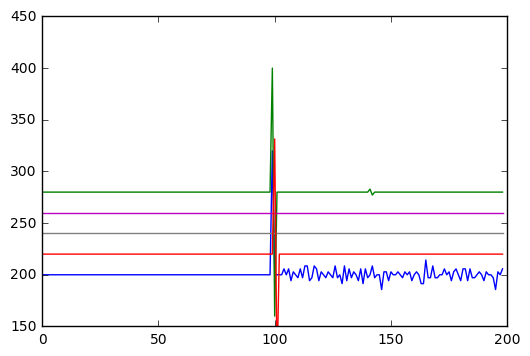

In [61]:
start_window = 0
n_windows = 1
plot_channels(start_window, n_windows)

id: 600
Mills: noSV


IndexError: index 5 is out of bounds for axis 0 with size 5

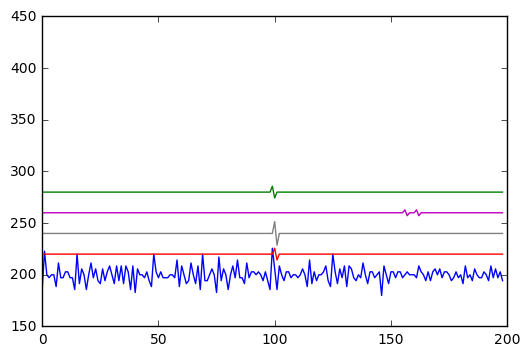

In [37]:
n_windows = 50
start_window = 600
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [60]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_test[0][0])
print(len(X_test[0][0]))

199


## Prepare the labels in McFly format

In [49]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'DEL_start': 1, 'DEL_end': 0, 'noSV': 2}


In [50]:
#y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
#y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
#y_train_binary = to_categorical(y_train)
#y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [51]:
y_test_binary

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [41]:
y_val_binary

NameError: name 'y_val_binary' is not defined

In [ ]:
X_train.shape

##  Generate and train neural networks 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [ ]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_filters = 3, 
                                  cnn_max_filters = 3, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=2,
                                  low_lr=1.73, high_lr=1.73,
                                  kernel_size = 11)

In [ ]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=2,
                                  cnn_max_layers=2,
                                  cnn_min_filters = 4, 
                                  cnn_max_filters = 4, 
                                  cnn_min_fc_nodes=6, 
                                  cnn_max_fc_nodes=6,
                                  low_lr=2, high_lr=2,
                                  kernel_size = 7)

In [ ]:
%%time
i=0
for model, params, model_types in models:
    print('model ' + str(i))
    i=i+1
    print(params)
    model.summary()

In [ ]:
train_set_size = X_train.shape[0]
train_set_size

In [ ]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=1, 
                                                                                 subset_size=train_set_size,
                                                                                 verbose=True)

## Save the best model

In [ ]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

In [ ]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_x_9')

best_model.save(model_path)

## Train the best model on the full dataset

In [ ]:
#We make a copy of the model, to start training from fresh
nr_epochs = 1
datasize = train_set_size # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

## Reload the trained model

In [52]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_13_9')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [53]:

model = model_reloaded 
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [54]:
mapclasses = {'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [55]:
labels = [i[0] for i in dict_sorted]

In [56]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,DEL_end,DEL_start,noSV
DEL_end,200,2,6
DEL_start,1,241,7
noSV,1,1,226


## Test best current model on testset

### Overall accuracy on the test set:

In [57]:
%%time
score_test = model.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.18073233751049878, 0.97372262773722629]
Wall time: 236 ms
